# **Consulting Project: Freezing of Gait**

https://www.kaggle.com/competitions/tlvmc-parkinsons-freezing-gait-prediction

-------------------
-------------------

## **The Dirty Work:**  Loading Data

In [ ]:
#mounting drive to get it started
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing packages
import pandas as pd
import numpy as np
import glob
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
#anova packages
import statsmodels.api as smapi
import statsmodels.formula.api as smf
import statsmodels.stats as stats
#model packages
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
#performance measurement packages
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
#entra fun stuff
from sklearn.model_selection import train_test_split

tDCSFOG: data series collected in the lab (FOG episodes are recorded on video)

In [ ]:
tdcsfog_meta = pd.read_csv('/content/drive/MyDrive/tdcsfog_metadata.csv')

In [ ]:
#importing extra overview data
subjects = pd.read_csv('/content/drive/MyDrive/subjects.csv')

In [ ]:
#importing tdcsfog training data. This approach is super ugly but it works: I aggregated 833 individual patient files into 7 parts (limited by csv size), now we're uploading and concatenating them again
onet = pd.read_csv('/content/drive/MyDrive/1t.csv')
twot = pd.read_csv('/content/drive/MyDrive/2t.csv')
threet = pd.read_csv('/content/drive/MyDrive/3t.csv')
fourt = pd.read_csv('/content/drive/MyDrive/4t.csv')
fivet = pd.read_csv('/content/drive/MyDrive/5t.csv')
sixt = pd.read_csv('/content/drive/MyDrive/6t.csv')
sevent = pd.read_csv('/content/drive/MyDrive/7t.csv')

In [ ]:
train_tdcsfog = pd.concat([onet, twot, threet, fourt, fivet, sixt, sevent])

-------------------
-------------------

Cleaning up the train set

In [ ]:
#Let's get rid of the first nonsense column: the source name is the patient Id, so we'll split and drop the excess
train_tdcsfog[['Id', 'File']] = train_tdcsfog['Source.Name'].str.split('.',expand=True)

In [ ]:
train_tdcsfog = train_tdcsfog.drop(columns=['Source.Name', 'File'])

In [ ]:
train_tdcsfog.head()

In [ ]:
#now, the above is perfectly fine but there's something slightly disturbing about having the Id at the end, so let's move it for aesthetic's sake
train_tdcsfog = train_tdcsfog[['Id', 'Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn', 'Walking']]

In [ ]:
train_tdcsfog.head() #much nicer

Let's see if we can map in some of our other info for these Id's using the meta data files

In [ ]:
#merging the two data sets based on the Id column
train_tdcsfog1 = train_tdcsfog.merge(tdcsfog_meta, how='inner', on='Id')

In [ ]:
train_tdcsfog1.head()

,Id,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Subject,Visit_x,Test,Medication,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ
0,003f117e14,0,-9.533939,0.566322,-1.413525,0,0,0,4dc2f8,3,2,0,68,1,9.0,17.0,15.0,15
1,003f117e14,1,-9.536140,0.564137,-1.440621,0,0,0,4dc2f8,3,2,0,68,1,9.0,17.0,15.0,15
2,003f117e14,2,-9.529345,0.561765,-1.429332,0,0,0,4dc2f8,3,2,0,68,1,9.0,17.0,15.0,15
3,003f117e14,3,-9.531239,0.564227,-1.415490,0,0,0,4dc2f8,3,2,0,68,1,9.0,17.0,15.0,15
4,003f117e14,4,-9.540825,0.561854,-1.429471,0,0,0,4dc2f8,3,2,0,68,1,9.0,17.0,15.0,15


In [ ]:
train_tdcsfog1.isnull().sum()

In [ ]:
#nice, let's see if we can do it again, but this time matching subjects
train_tdcsfog1 = train_tdcsfog1.merge(subjects, how='inner', on='Subject')

In [ ]:
train_tdcsfog1.head()

In [ ]:
train_tdcsfog1.describe()

In [ ]:
train_tdcsfog1.isnull().sum()

This file is big enough as it is, let's chop the unhelpful sections

In [ ]:
train_tdcsfog1 = train_tdcsfog1.drop('Visit_y', axis=1)

In [ ]:
#double check
train_tdcsfog1.head()

-------------------
-------------------

# **Feature Engineering** for some mapped categorical variables

Let's check data types

In [ ]:
train_tdcsfog1.dtypes

In [ ]:
for col in ['Id','Subject', 'Medication', 'Sex']:
    train_tdcsfog1[col] = train_tdcsfog1[col].astype('category')

In [ ]:
#let's give ourselves a new dataset
train_tdcsfog1_map = train_tdcsfog1

In [ ]:
a = {'on': 0, 'off': 1}
train_tdcsfog1_map['Medication'] = train_tdcsfog1_map['Medication'].map(a)

In [ ]:
b = {'M': 0, 'F': 1}
train_tdcsfog1_map['Sex'] = train_tdcsfog1_map['Sex'].map(b)

In [ ]:
#now we're changing the mapped types to int's
train_tdcsfog1_map['Medication'] = train_tdcsfog1_map['Medication'].astype('int64')
train_tdcsfog1_map['Sex'] = train_tdcsfog1_map['Sex'].astype('int64')

In [ ]:
train_tdcsfog1_map.dtypes

-------------------
-------------------

For posterity's sake (and the fact that my GPU maxes in the later part of the code), we're going to save the edited data sets so we can just jump to these later.

In [ ]:
#convert our dataframes back to csv
train_tdcsfog1.to_csv('train_tdcsfog1.csv')
train_tdcsfog1_map.to_csv('train_tdcsfog1_map.csv')

In [ ]:
from google.colab import files
files.download('train_tdcsfog1.csv')
files.download('train_tdcsfog1_map.csv')

And adding an upload line for potential use later

In [ ]:
train_tdcsfog1 = pd.read_csv('/content/drive/MyDrive/train_tdcsfog1.csv', index_col=[0])

<ipython-input-3-0bfac6065683>:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  train_tdcsfog1 = pd.read_csv('/content/drive/MyDrive/train_tdcsfog1.csv', index_col=[0])


In [ ]:
train_tdcsfog1_map = pd.read_csv('/content/drive/MyDrive/train_tdcsfog1_map.csv')

-------------------
-------------------

# **EDA**: Everyone (likes) Data Always

We really want to get an idea of what our data looks like so let's start with the basics

In [ ]:
train_tdcsfog1[['Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn', 'Walking', 'Visit_x', 'Test', 'Medication', 'Age', 'YearsSinceDx']].describe()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Visit_x,Test,Medication,Age,YearsSinceDx
count,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06
mean,9.289467e+03,-9.306317e+00,-2.012513e-01,1.808524e+00,4.315506e-02,2.376979e-01,2.942767e-02,7.352151e+00,2.093533e+00,3.971565e-01,6.972636e+01,9.119993e+00
std,1.399893e+04,1.080174e+00,1.269525e+00,2.285849e+00,2.032061e-01,4.256731e-01,1.690020e-01,6.779498e+00,8.301861e-01,4.893089e-01,7.717013e+00,5.789700e+00
min,0.000000e+00,-3.552112e+01,-2.616440e+01,-4.782964e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,5.100000e+01,1.000000e+00
25%,2.119000e+03,-9.762402e+00,-9.295446e-01,5.672254e-01,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,6.600000e+01,4.000000e+00
50%,4.310000e+03,-9.363524e+00,-1.722245e-01,1.987101e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,2.000000e+00,0.000000e+00,7.100000e+01,8.000000e+00
75%,8.433000e+03,-8.776814e+00,5.752114e-01,3.449026e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.300000e+01,3.000000e+00,1.000000e+00,7.400000e+01,1.200000e+01
max,9.707600e+04,2.090695e+01,2.748472e+01,3.033769e+01,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+01,3.000000e+00,1.000000e+00,9.400000e+01,2.300000e+01


In [ ]:
len(train_tdcsfog1.Id)

7062672

In [ ]:
len(train_tdcsfog1.Subject.unique())

65

In [ ]:
train_tdcsfog1.Subject.value_counts()

2d57c2    1052819
d9312a     221504
79011a     200995
194d1d     186621
3b2b7a     183478
           ...   
082f01      23964
9f85da      20742
364459      19179
c85fdf      13946
51574c       9500
Name: Subject, Length: 65, dtype: int64

In [ ]:
train_tdcsfog1.shape

(7062672, 18)

<Axes: >

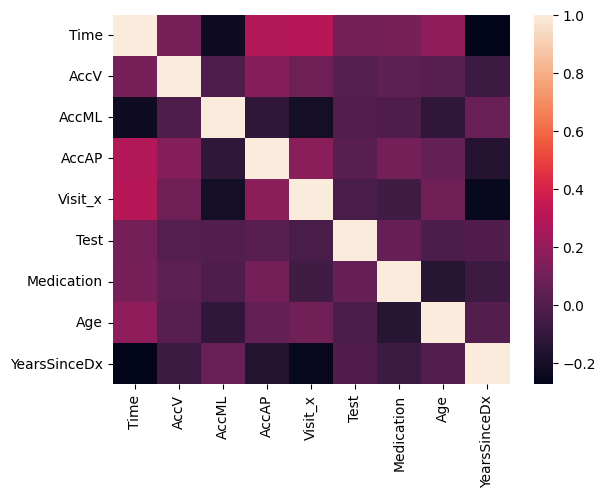

In [ ]:
sns.heatmap(data = train_tdcsfog1[['Time', 'AccV', 'AccML', 'AccAP', 'Visit_x', 'Test', 'Medication', 'Age', 'YearsSinceDx']].corr())

In [ ]:
sns.pairplot(data = train_tdcsfog1)

In [ ]:
temp = len(train_tdcsfog1)
print(
    f"Length of the tdcsfog_metadata.csv file is:{temp}",
)

In [ ]:
unique_age = train_tdcsfog1

drop = ['Id', 'Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn', 'Visit_x', 'Walking', 'Test', 'Medication', 'YearsSinceDx', 'UPDRSIII_On', 'UPDRSIII_Off', 'NFOGQ']

unique_age = unique_age.drop(drop, axis=1)

310 visits and 839 tests

In [ ]:
unique_age.head()

,Subject,Age,Sex
0,4dc2f8,68,1
1,4dc2f8,68,1
2,4dc2f8,68,1
3,4dc2f8,68,1
4,4dc2f8,68,1


In [ ]:
unique_age.shape

(7062672, 3)

In [ ]:
unique_age.drop_duplicates()

,Subject,Age,Sex
0,4dc2f8,68,1
102910,231c3b,67,0
247096,31d269,72,0
376301,07285e,58,0
505658,220a17,63,0
...,...,...,...
6666552,c7fee4,80,0
6711344,082f01,64,0
6735308,f686f0,61,0
6810625,e8919c,94,0


from matplotlib import pyplot as plt
_df_0['Age'].plot(kind='hist', bins=20, title='Age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Sex'].plot(kind='hist', bins=20, title='Sex')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='Age', y='Sex', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Age'].plot(kind='line', figsize=(8, 4), title='Age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['Sex'].plot(kind='line', figsize=(8, 4), title='Sex')
plt.gca().spines[['top', 'right']].set_visible(False)

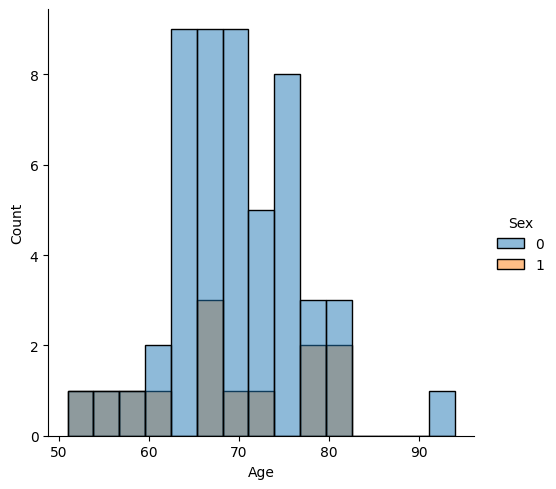

In [ ]:
sns.displot(x=_df_0['Age'], hue=_df_0['Sex'], bins = 15)

In [ ]:
unique_med = train_tdcsfog1

drop = ['Id', 'Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn', 'Walking', 'Test', 'Age', 'Sex', 'YearsSinceDx', 'UPDRSIII_On', 'UPDRSIII_Off', 'NFOGQ']

unique_med = unique_med.drop(drop, axis=1)

In [ ]:
unique_med.head()

,Subject,Visit_x,Medication
0,4dc2f8,3,0
1,4dc2f8,3,0
2,4dc2f8,3,0
3,4dc2f8,3,0
4,4dc2f8,3,0


In [ ]:
unique_med.drop_duplicates()

,Subject,Visit_x,Medication
0,4dc2f8,3,0
4682,4dc2f8,2,0
11683,4dc2f8,4,0
17907,4dc2f8,2,1
25342,4dc2f8,3,1
...,...,...,...
6752740,f686f0,2,0
6810625,e8919c,2,0
6818188,e8919c,13,0
6829398,e8919c,2,1


from matplotlib import pyplot as plt
_df_7['Visit_x'].plot(kind='hist', bins=20, title='Visit_x')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['Medication'].plot(kind='hist', bins=20, title='Medication')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='Visit_x', y='Medication', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Visit_x'].plot(kind='line', figsize=(8, 4), title='Visit_x')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Medication'].plot(kind='line', figsize=(8, 4), title='Medication')
plt.gca().spines[['top', 'right']].set_visible(False)

<Axes: xlabel='Medication', ylabel='count'>

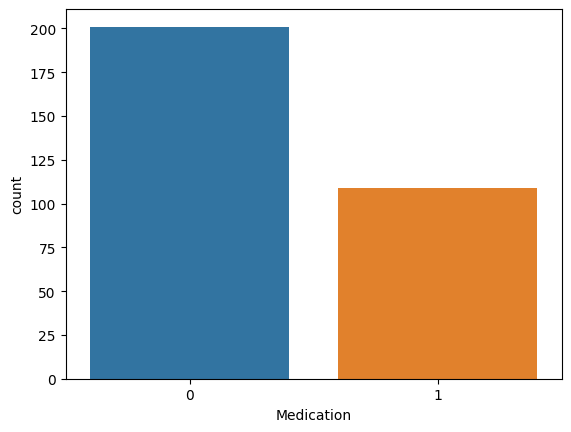

In [ ]:
sns.countplot(x='Medication', data=_df_7)

In [ ]:
unique_visit = train_tdcsfog1

drop = ['Id', 'Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn', 'Walking', 'Test', 'Age', 'Sex', 'Medication', 'YearsSinceDx', 'UPDRSIII_On', 'UPDRSIII_Off', 'NFOGQ']

unique_visit = unique_visit.drop(drop, axis=1)

In [ ]:
unique_visit.head()

,Subject,Visit_x
0,4dc2f8,3
1,4dc2f8,3
2,4dc2f8,3
3,4dc2f8,3
4,4dc2f8,3


In [ ]:
unique_visit.drop_duplicates()

,Subject,Visit_x
0,4dc2f8,3
4682,4dc2f8,2
11683,4dc2f8,4
102910,231c3b,2
110030,231c3b,3
...,...,...
6749232,f686f0,4
6752740,f686f0,2
6810625,e8919c,2
6818188,e8919c,13


from matplotlib import pyplot as plt
_df_12['Visit_x'].plot(kind='hist', bins=20, title='Visit_x')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_13['Visit_x'].plot(kind='line', figsize=(8, 4), title='Visit_x')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
train_tdcsfog1['Age'].hist()

In [ ]:
train_tdcsfog1.drop(columns=['UPDRSIII_On', 'UPDRSIII_Off', 'NFOGQ'])

In [ ]:
train_tdcsfog1.describe()

In [ ]:
#unique participants
train_tdcsfog1['Subject'].nunique()

In [ ]:
sns.barplot(x='Medication', y='StartHesitation', data = train_tdcsfog1)

In [ ]:
sns.barplot(x='Medication', y='Turn', data = train_tdcsfog1)

In [ ]:
sns.barplot(x='Medication', y='Walking', data = train_tdcsfog1)

In [ ]:
cols2 = train_tdcsfog1[['AccAP', 'AccV', 'AccML']]

In [ ]:
sns.lineplot(x = "Time", y = "AccV", data = train_tdcsfog1)

In [ ]:
sns.lineplot(x = "Time", y = "AccAP", data = train_tdcsfog1)

In [ ]:
sns.lineplot(x = "Time", y = "AccML", data = train_tdcsfog1)

In [ ]:
train_tdcsfog1.nunique(axis = 1)

<Axes: xlabel='Visit_x', ylabel='count'>

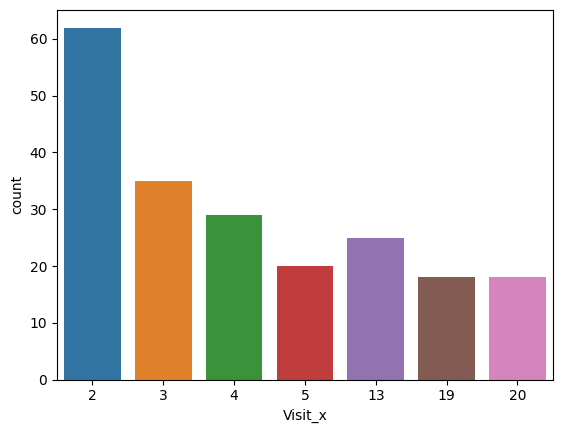

In [ ]:
sns.countplot(x='Visit_x', data=_df_12)

-------------------
-------------------

# **Analysis**

Bring out the Models!!! XGBoost, LightGBM, Random Forest, and Histogram Boosting Gradient Classifier models that is.

We're going to evaluate these on F1 score and Accuracy Score.

*   F1 Score: F1 = 2 * (precision * recall) / (precision + recall)
 *  The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
*   Accuracy Score: function from the sklearn package, computes subset acuracy for exact matches







-------------------
-------------------

# **Feature Selection: PCA for Turn**

In [ ]:
#first we're going to need to denote our x and y
drop_cols = ['StartHesitation', 'Turn', 'Walking', 'Id', 'Subject', 'UPDRSIII_On', 'UPDRSIII_Off', 'NFOGQ']

x = train_tdcsfog1.drop(drop_cols, axis=1)
y = train_tdcsfog1['Turn']

In [ ]:
x.head()

,Time,AccV,AccML,AccAP,Visit_x,Test,Medication,Age,Sex,YearsSinceDx,NFOGQ
0,0,-9.533939,0.566322,-1.413525,3,2,0,68,1,9.0,15
1,1,-9.536140,0.564137,-1.440621,3,2,0,68,1,9.0,15
2,2,-9.529345,0.561765,-1.429332,3,2,0,68,1,9.0,15
3,3,-9.531239,0.564227,-1.415490,3,2,0,68,1,9.0,15
4,4,-9.540825,0.561854,-1.429471,3,2,0,68,1,9.0,15


In [ ]:
#now we want our test and train data from our existing triaining set
#by splitting these, we'll be able to determine accuracy since we are already provided the full range of data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
#PCA proprossessing
x_train_PCA = x_train
x_test_PCA = x_test
sc = StandardScaler()
x_train_PCA = sc.fit_transform(x_train)
x_test_PCA = sc.transform(x_test)

In [ ]:
pca = PCA(n_components = 6)

x_train_PCA = pca.fit_transform(x_train_PCA)
x_test_PCA = pca.transform(x_test_PCA)

In [ ]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], index=x_test.columns)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6
Time,-0.537186,0.032533,-0.036418,0.182997,-0.000214,-0.047295
AccV,-0.209691,0.064301,-0.440532,-0.419450,0.251203,0.652346
AccML,0.331093,0.119594,-0.310953,-0.278448,0.466906,-0.286269
AccAP,-0.399882,0.092729,-0.335328,-0.120717,-0.216658,-0.062232
Visit_x,-0.446206,-0.163271,0.194357,-0.158104,0.130369,-0.288962
Test,-0.061874,0.241869,-0.259327,0.736847,0.497661,0.018301
Medication,-0.089089,0.597315,-0.205758,0.101104,-0.495221,-0.032752
Age,-0.206788,-0.543016,0.010919,0.251848,0.015245,0.301424
Sex,0.029492,0.405830,0.607518,0.002757,0.127917,0.493145
YearsSinceDx,0.378731,-0.265327,-0.280908,0.238475,-0.381384,0.259674


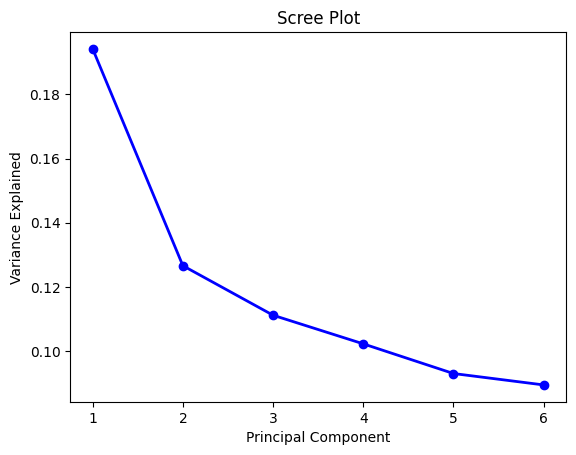

In [ ]:
#scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [ ]:
print(pca.explained_variance_ratio_)

[0.19416934 0.12658379 0.1111504  0.10222896 0.09297664 0.08942224]


We definitely see a big elbow at the second principal component but probably want to include up to the 4th to be thorough.

But! Given the dimensions we have, this doesn't seem like it's going to be too helpful. We're trying to reduce down 8 predictors, not 100.

-------------------
-------------------

# **ANOVA for Turn - a BUST**

That data is not ok for ANOVA

In [ ]:
column_headers = list(train_tdcsfog1.columns.values)
print("The Column Header :", column_headers)

The Column Header : ['Id', 'Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn', 'Walking', 'Subject', 'Visit_x', 'Test', 'Medication', 'Age', 'Sex', 'YearsSinceDx', 'UPDRSIII_On', 'UPDRSIII_Off', 'NFOGQ']


In [ ]:
model = smf.ols(formula='Turn ~ Time + AccV + AccML + AccAP + Visit_x + Test + Medication + Age + Sex + YearsSinceDx', data=train_tdcsfog1)

In [ ]:
Fit_model = model.fit()
Fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Turn   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                 1.906e+05
Date:                Fri, 01 Dec 2023   Prob (F-statistic):               0.00
Time:                        06:54:25   Log-Likelihood:            -3.1456e+06
No. Observations:             7062672   AIC:                         6.291e+06
Df Residuals:                 7062661   BIC:                         6.291e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.2166      0.002   -112.999      0.000      -0.220      -0.213
Time          1.078e-05   1.17e-08    921.813      0.000    1.08e-05    1.08e-05
AccV             0.0010      0.000      7.648      0.000       0.001       0.001
AccML            0.0055      0.000     47.035      0.000       0.005       0.006
AccAP            0.0264   6.62e-05    399.195      0.000       0.026       0.027
Visit_x         -0.0043   2.29e-05   -189.327      0.000      -0.004      -0.004
Test            -0.0046      0.000    -26.843      0.000      -0.005      -0.004
Medication       0.0723      0.000    241.132      0.000       0.072       0.073
Age              0.0054   1.92e-05    280.896      0.000       0.005       0.005
Sex             -0.0342      0.000    -91.494      0.000      -0.035      -0.033
YearsSinceDx    -0.0043   2.64e-05   -162.831      0.000      -0.004      -0.004
==============================================================================
Omnibus:                   789940.755   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1086894.606
Skew:                           0.955   Prob(JB):                         0.00
Kurtosis:                       3.210   Cond. No.                     2.27e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
#Now a Type III One-Way ANOVA model
smapi.stats.anova_lm(Fit_model, typ=3)

,sum_sq,df,F,PR(>F)
Intercept,1.821920e+03,1.0,12768.709698,0.000000e+00
Time,1.212461e+05,1.0,849738.341356,0.000000e+00
AccV,8.346462e+00,1.0,58.495172,2.038160e-14
AccML,3.156601e+02,1.0,2212.265861,0.000000e+00
AccAP,2.273796e+04,1.0,159356.259929,0.000000e+00
Visit_x,5.114570e+03,1.0,35844.845513,0.000000e+00
Test,1.028126e+02,1.0,720.549724,1.035443e-158
Medication,8.296428e+03,1.0,58144.516222,0.000000e+00
Age,1.125830e+04,1.0,78902.419927,0.000000e+00
Sex,1.194440e+03,1.0,8371.089484,0.000000e+00


Assumption Check

In [ ]:
#Anderson Darling test for normality
stats.diagnostic.normal_ad(Fit_model.resid_pearson)
#AD test stat = 525569.79, p-value = approx 0.0
#We have a violation of the normality assumption

(525569.786531047, 0.0)

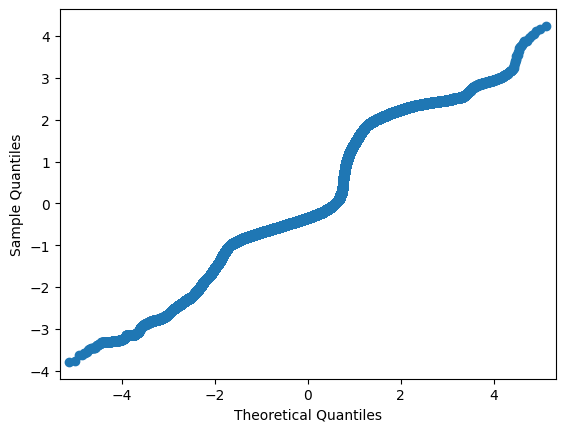

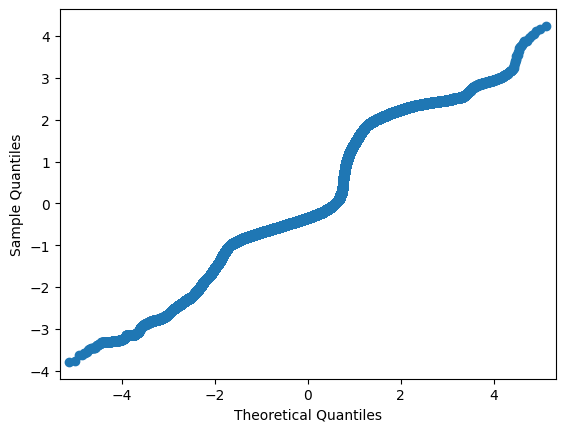

In [ ]:
#Normal probability plot
smapi.qqplot(Fit_model.resid_pearson)
#Honestly, it deviates but it's not that bad

In [ ]:
#Breusch-Pagan test for equal variance
stats.diagnostic.het_breuschpagan(Fit_model.resid_pearson, Fit_model.model.exog)
#the p-values here are small enough that we have evidence of an equal variance violation

(787700.6632991832, 0.0, 88657.97875153743, 0.0)

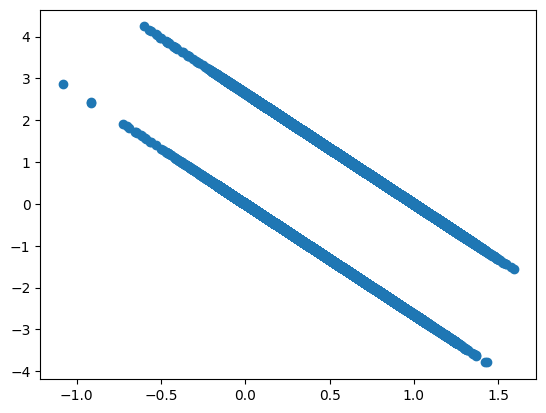

In [ ]:
#residual plot
plt.scatter(Fit_model.fittedvalues, Fit_model.resid_pearson)
#yup, crazy non-random

-------------------
-------------------

# **Predicting Turn: XGBoost** first!

In [ ]:
#first we're going to need to denote our x and y
drop_cols = ['Time', 'StartHesitation', 'Turn', 'Walking', 'Id', 'Subject']

x = train_tdcsfog1.drop(drop_cols, axis=1)
y = train_tdcsfog1['Turn']

In [ ]:
#now we want our test and train data from our existing triaining set
#by splitting these, we'll be able to determine accuracy since we are already provided the full range of data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
x_train.shape

In [ ]:
def test_model(algorithm, x_train, y_train, x_test, y_test):

    model = algorithm()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)


    return f1, accuracy

**ATTEMPT 1**

In [ ]:
f1_xgb, accuracy_xgb = test_model(XGBClassifier, x_train, y_train, x_test, y_test)

print(f"F1 score - {f1_xgb}, | Accuracy - {accuracy_xgb}")

Decent model, 87.77% accurate

**ATTEMPT 2**

In [ ]:
# create model instance
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')

In [ ]:
# fit model
bst.fit(x_train, y_train)

In [ ]:
# make predictions
preds = bst.predict(x_test)

In [ ]:
f1 = f1_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)

print(f"F1 score - {f1}, | Accuracy - {accuracy}")

Not quite as good as the first, 80.66% accurate

-------------------
-------------------

# **LightGBM**

**ATTEMPT 1**

In [ ]:
f1_lgbm, accuracy_lgbm = test_model(LGBMClassifier, x_train, y_train, x_test, y_test)

print(f"F1 score - {f1_lgbm}, | Accuracy - {accuracy_lgbm}")

Pretty good! 86.90% accurate

-------------------
-------------------

# **Random Forest**

This model only uses numerical values.

**ATTEMPT 1**

One difference about random forests compared to the other models is its intolerance for missing values. Because of this, we'll remove the perpetrators and work with the subset:

In [ ]:
x_train.isna().sum()

In [ ]:
train_tdcsfog2 = train_tdcsfog1

train_tdcsfog2 = train_tdcsfog2.drop(columns=['UPDRSIII_On', 'UPDRSIII_Off'])

Then, with those out of the way, we'll redefine x and y and get the model going

In [ ]:
drop_cols = ['Time', 'StartHesitation', 'Turn', 'Walking', 'Id', 'Subject']

x_rf = train_tdcsfog2.drop(drop_cols, axis=1)
y_rf = train_tdcsfog2['Turn']

In [ ]:
#now the train-test split
x_rf_train, x_rf_test, y_rf_train, y_rf_test = train_test_split(x_rf, y_rf, test_size=0.3, random_state=1, stratify=y)

In [ ]:
f1_dtc, accuracy_dtc = test_model(DecisionTreeClassifier, x_rf_train, y_rf_train, x_rf_test, y_rf_test)

print(f"F1 score - {f1_dtc}, | Accuracy - {accuracy_dtc}")

Ok, not too bad, 86.06% accurate.

Looks like all models so far as performing roughly on the same level (XGBoost being the best so far)

Let's try one last one that I've had success with before: Histogram Boosting Gradient Classifier.

It's along the same lines as the others but let's see if we can do a little better.

-------------------
-------------------

# **Histogram Gradient Boosting Classifier**

In [ ]:
f1_hgbc, accuracy_hgbc = test_model(HistGradientBoostingClassifier, x_train, y_train, x_test, y_test)

print(f"F1 score - {f1_hgbc}, | Accuracy - {accuracy_hgbc}")

Ehh this is about the same, 86.86%. We might be at the capacity with what data we're using.

Maybe expanding the set with the defog data appended to the end could help get us a little more accurate. But until then, let's get a summary table going:

In [ ]:
index = ["XGBClassifier",
         "LGBMClassifier",
         "RandomForest",
         "HistGradientBoostingClassifier"]

data = {'F1 score':[f1_xgb.round(4),
                    f1_lgbm.round(4),
                    f1_dtc.round(4),
                    f1_hgbc.round(4)],

        'Accuracy':[accuracy_xgb.round(4),
                    accuracy_lgbm.round(4),
                    accuracy_dtc.round(4),
                    accuracy_hgbc.round(4)]
        }

pd.DataFrame(data=data, index=index)

-------------------
-------------------
 # **Starting over: combined analysis - a BUST**
 - let's use what we can overlap from defog and tdcsfog and see how that goes

In [ ]:
#let's get in the defog data
#one = pd.read_csv('/content/drive/MyDrive/1.csv')
#two = pd.read_csv('/content/drive/MyDrive/2.csv')
#three = pd.read_csv('/content/drive/MyDrive/3.csv')
#four = pd.read_csv('/content/drive/MyDrive/4.csv')
#five = pd.read_csv('/content/drive/MyDrive/5.csv')
#six = pd.read_csv('/content/drive/MyDrive/6.csv')
#seven = pd.read_csv('/content/drive/MyDrive/7.csv')
#eight = pd.read_csv('/content/drive/MyDrive/8.csv')
#nine = pd.read_csv('/content/drive/MyDrive/9.csv')
#ten = pd.read_csv('/content/drive/MyDrive/10.csv')
#eleven = pd.read_csv('/content/drive/MyDrive/11.csv')
#twelve = pd.read_csv('/content/drive/MyDrive/12.csv')
#thirteen = pd.read_csv('/content/drive/MyDrive/13.csv')
#fourteen = pd.read_csv('/content/drive/MyDrive/14.csv')
#fifteen = pd.read_csv('/content/drive/MyDrive/15.csv')

In [ ]:
#putting together the aggregated dataset
#train_defog = pd.concat([one, two, three, four, five, six, seven, eight, nine, ten, eleven, twelve, thirteen, fourteen, fifteen])

In [ ]:
#train_defog = train_defog.drop(columns=['Valid', 'Task']) #these are extra and add nothing to the actual analysis

In [ ]:
#transitioning Source.Name to Id
#train_defog[['Id', 'File']] = train_defog['Source.Name'].str.split('.',expand=True)
#train_defog = train_defog[['Id', 'Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn', 'Walking']]

In [ ]:
#merging defog and the meta on Id
#train_defog1 = train_defog.merge(defog_meta, how='inner', on='Id')

In [ ]:
#once more for the subjects
#train_defog1 = train_defog1.merge(subjects, how='inner', on='Subject')

In [ ]:
#train_defog1.head()

Again, let's apply some feature engineering

In [ ]:
#for col in ['Id','Subject', 'Medication', 'Sex']:
#    train_defog1[col] = train_defog1[col].astype('category')

In [ ]:
#let's give ourselves a new dataset
#train_defog1_map = train_defog1

In [ ]:
#a = {'on': 0, 'off': 1}
#train_defog1_map['Medication'] = train_defog1_map['Medication'].map(a)

In [ ]:
#b = {'M': 0, 'F': 1}
#train_defog1_map['Sex'] = train_defog1_map['Sex'].map(b)

In [ ]:
#now we're changing the mapped types to int's
#train_defog1_map['Medication'] = train_defog1_map['Medication'].astype('int64')
#train_defog1_map['Sex'] = train_defog1_map['Sex'].astype('int64')

Saving for my sanity

In [ ]:
#convert our dataframes back to csv
#train_defog1.to_csv('train_defog1.csv')
#train_defog1_map.to_csv('train_defog1_map.csv')

In [ ]:
#files.download('train_defog1.csv')
#files.download('train_defog1_map.csv')

Now we upload the data again

In [ ]:
#train_defog1 = pd.read_csv('/content/drive/MyDrive/train_defog1.csv')

In [ ]:
#train_defog1_map = pd.read_csv('/content/drive/MyDrive/train_defog1_map.csv')

Now let's aggregate and hope for the best...

No such luck, I've tried several times but it exceeds RAM/ GPU capacity.. but we can try again with the defog dataset and see if it matches up.

-------------------
-------------------

# **Predicting for StartHesitation**

Due to the size of the combined data, there's just not a way we can analyze that... Nothing more to say. Instead, we're going to move forward with the other types of freezing of gait events and see if we have better predictions for one type or another

In [ ]:
train_tdcsfog1.rename(columns={"Visit_x": "Visit"})

In [ ]:
train_tdcsfog1 = train_tdcsfog1.drop(columns=['UPDRSIII_On','UPDRSIII_Off'])

In [ ]:
#first we're going to need to denote our x and y
drop_cols = ['Time', 'StartHesitation', 'Turn', 'Walking', 'Id', 'Subject']

x = train_tdcsfog1.drop(drop_cols, axis=1)
y = train_tdcsfog1['StartHesitation']

In [ ]:
train_tdcsfog1.isna().sum()

In [ ]:
#test/ train split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=17, stratify=y)

XGBoost

In [ ]:
f1_xgb, accuracy_xgb = test_model(XGBClassifier, x_train, y_train, x_test, y_test)

print(f"F1 score - {f1_xgb}, | Accuracy - {accuracy_xgb}")

LightGBM

In [ ]:
f1_lgbm, accuracy_lgbm = test_model(LGBMClassifier, x_train, y_train, x_test, y_test)

print(f"F1 score - {f1_lgbm}, | Accuracy - {accuracy_lgbm}")

Random Forest

In [ ]:
f1_rf, accuracy_rf = test_model(DecisionTreeClassifier, x_train, y_train, x_test, y_test)

print(f"F1 score - {f1_rf}, | Accuracy - {accuracy_rf}")

Histogram Gradient Boosting

In [ ]:
f1_hgbc, accuracy_hgbc = test_model(HistGradientBoostingClassifier, x_train, y_train, x_test, y_test)

print(f"F1 score - {f1_hgbc}, | Accuracy - {accuracy_hgbc}")

Summary Table

In [ ]:
index = ["XGBClassifier",
         "LGBMClassifier",
         "RandomForest",
         "HistGradientBoostingClassifier"]

data = {'F1 score':[f1_xgb.round(4),
                    f1_lgbm.round(4),
                    f1_rf.round(4),
                    f1_hgbc.round(4)],

        'Accuracy':[accuracy_xgb.round(4),
                    accuracy_lgbm.round(4),
                    accuracy_rf.round(4),
                    accuracy_hgbc.round(4)]
        }

pd.DataFrame(data=data, index=index)

-------------------
-------------------

# **Predicting for Walking**

Alright people, let's do this one last time. My name is Peter B Parker.. Wait-

One last time for the Walking FOG type

XGBoost

In [ ]:
drop_cols = ['Time', 'StartHesitation', 'Turn', 'Walking', 'Id', 'Subject']

x = train_tdcsfog1.drop(drop_cols, axis=1)
y = train_tdcsfog1['Walking']

In [ ]:
#test/ train split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=44, stratify=y)

In [ ]:
f1_xgb, accuracy_xgb = test_model(XGBClassifier, x_train, y_train, x_test, y_test)

print(f"F1 score - {f1_xgb}, | Accuracy - {accuracy_xgb}")

LightGBM

In [ ]:
f1_lgbm, accuracy_lgbm = test_model(LGBMClassifier, x_train, y_train, x_test, y_test)

print(f"F1 score - {f1_lgbm}, | Accuracy - {accuracy_lgbm}")

Random Forest

In [ ]:
f1_rf, accuracy_rf = test_model(DecisionTreeClassifier, x_train, y_train, x_test, y_test)

print(f"F1 score - {f1_rf}, | Accuracy - {accuracy_rf}")

HGBoosting

In [ ]:
f1_hgbc, accuracy_hgbc = test_model(HistGradientBoostingClassifier, x_train, y_train, x_test, y_test)

print(f"F1 score - {f1_hgbc}, | Accuracy - {accuracy_hgbc}")

In [ ]:
index = ["XGBClassifier",
         "LGBMClassifier",
         "RandomForest",
         "HistGradientBoostingClassifier"]

data = {'F1 score':[f1_xgb.round(4),
                    f1_lgbm.round(4),
                    f1_rf.round(4),
                    f1_hgbc.round(4)],

        'Accuracy':[accuracy_xgb.round(4),
                    accuracy_lgbm.round(4),
                    accuracy_rf.round(4),
                    accuracy_hgbc.round(4)]
        }

pd.DataFrame(data=data, index=index)

-------------------
-------------------
# **Multiclass Classification**


In [ ]:
drop_cols = ['Time', 'StartHesitation', 'Turn', 'Walking', 'Id', 'Subject', 'UPDRSIII_On', 'UPDRSIII_Off']
y_cols = ['StartHesitation', 'Turn', 'Walking']

x = train_tdcsfog1.drop(drop_cols, axis=1)
y = train_tdcsfog1[y_cols]

In [ ]:
#now we want our test and train data from our existing triaining set
#by splitting these, we'll be able to determine accuracy since we are already provided the full range of data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
x_train.shape

(4943870, 12)

In [ ]:
y_train.shape

(4943870, 3)

In [ ]:
def test_model(algorithm, x_train, y_train, x_test, y_test):

    model = algorithm()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)


    return f1, accuracy

**XGBoost**

In [ ]:
f1_xgb, accuracy_xgb = test_model(XGBClassifier, x_train, y_train, x_test, y_test)

print(f"F1 score - {f1_xgb}, | Accuracy - {accuracy_xgb}")

F1 score - 0.6796088103765503, | Accuracy - 0.8575237327508658


F1 score - 0.6796088103765503, | Accuracy - 0.8575237327508658

**LightGBM**


Some prep work: we need to code our indicators into a single column so we can use that as our y

In [ ]:
y_cols_combined = train_tdcsfog1[y_cols]

In [ ]:
y_cols_combined.loc[(y_cols_combined.StartHesitation == 1), "y_comb"] = "StartHesitation"

y_cols_combined.loc[(y_cols_combined.Turn == 1), "y_comb"] = "Turn"

y_cols_combined.loc[(y_cols_combined.Walking == 1), "y_comb"] = "Walking"

y_cols_combined.loc[(y_cols_combined.StartHesitation == 0) & (y_cols_combined.Turn == 0) & (y_cols_combined.Walking == 0), "y_comb"] = "NO"

In [ ]:
y_cols_combined = y_cols_combined.drop(y_cols, axis=1)

In [ ]:
y_cols_combined.describe()

In [ ]:
#reassigning x and y
x_comb = train_tdcsfog1.drop(drop_cols, axis=1)
y_comb = y_cols_combined

In [ ]:
#now we want our test and train data from our existing triaining set
#by splitting these, we'll be able to determine accuracy since we are already provided the full range of data
x_comb_train, x_comb_test, y_comb_train, y_comb_test = train_test_split(x_comb, y_comb, test_size=0.3, random_state=1, stratify=y)

In [ ]:
f1_lgbm, accuracy_lgbm = test_model(LGBMClassifier, x_comb_train, y_comb_train, x_comb_test, y_comb_test)

print(f"F1 score - {f1_lgbm}, | Accuracy - {accuracy_lgbm}")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.582621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 850
[LightGBM] [Info] Number of data points in the train set: 4943870, number of used features: 10
[LightGBM] [Info] Start training from score -0.371470
[LightGBM] [Info] Start training from score -3.142956
[LightGBM] [Info] Start training from score -1.436755
[LightGBM] [Info] Start training from score -3.525817
F1 score - 0.8533101809428022, | Accuracy - 0.859785860122843


F1 score - 0.8533101809428022, | Accuracy - 0.859785860122843

**Random Forest**

In [ ]:
x_train.isna().sum()

In [ ]:
drop_cols = ['Time', 'StartHesitation', 'Turn', 'Walking', 'Id', 'Subject', 'UPDRSIII_On', 'UPDRSIII_Off']
y_cols = ['StartHesitation', 'Turn', 'Walking']

x_rf = train_tdcsfog1.drop(drop_cols, axis=1)
y_rf = train_tdcsfog1[y_cols]

In [ ]:
#now the train-test split
x_rf_train, x_rf_test, y_rf_train, y_rf_test = train_test_split(x_rf, y_rf, test_size=0.3, random_state=1, stratify=y)

In [ ]:
f1_dtc, accuracy_dtc = test_model(DecisionTreeClassifier, x_rf_train, y_rf_train, x_rf_test, y_rf_test)

print(f"F1 score - {f1_dtc}, | Accuracy - {accuracy_dtc}")

F1 score - 0.6547257521038308, | Accuracy - 0.8433964098580236


F1 score - 0.6547257521038308, | Accuracy - 0.8433964098580236

HGB Classifier

In [ ]:
f1_hgbc, accuracy_hgbc = test_model(HistGradientBoostingClassifier, x_comb_train, y_comb_train, x_comb_test, y_comb_test)

print(f"F1 score - {f1_hgbc}, | Accuracy - {accuracy_hgbc}")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


F1 score - 0.8471543612195386, | Accuracy - 0.8546607941657597


F1 score - 0.8471543612195386, | Accuracy - 0.8546607941657597

In [ ]:
index = ["Multiclass XGBClassifier",
         "Multiclass LGBMClassifier",
         "Multiclass RandomForest",
         "Multiclass HistGradientBoostingClassifier"]

data = {'F1 score':[f1_xgb.round(4),
                    f1_lgbm.round(4),
                    f1_dtc.round(4),
                    f1_hgbc.round(4)],

        'Accuracy':[accuracy_xgb.round(4),
                    accuracy_lgbm.round(4),
                    accuracy_dtc.round(4),
                    accuracy_hgbc.round(4)]
        }

pd.DataFrame(data=data, index=index)

,F1 score,Accuracy
Multiclass XGBClassifier,0.6796,0.8575
Multiclass LGBMClassifier,0.8533,0.8598
Multiclass RandomForest,0.6547,0.8434
Multiclass HistGradientBoostingClassifier,0.8472,0.8547
